# Tension estimate for non-Gaussian distributions

Cyrille Doux (<doux@lpsc.in2p3.fr>), Marco Raveri (<marco.raveri@unige.it>)

In this notebook we show how to calculate the level of tension between two experiments.

In particular we show how to compute the statistical significance of a parameter shift between two experiments, DES Y1 and Planck 18, with the two techniques discussed in 
[Raveri and Doux (2021), arXiv:2105.03324](https://arxiv.org/abs/2105.03324).

In [1]:
# Show plots inline, and load main getdist plot module and samples class
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 1
# import libraries:
import sys, os
sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'../..')))
from getdist import plots
import getdist
getdist.chains.print_load_details = False

# import the tensiometer tools that we need:
import tensiometer
from tensiometer import utilities
from tensiometer import mcmc_tension

2024-07-19 16:24:04.456637: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


We start importing the relevant samples. 
The code requires the two chains to be getdist MCSamples objects.
Check [GetDist documentation](https://getdist.readthedocs.io/en/latest/) for example codes of how to import or create them.


In [2]:
# load the samples (remove no burn in since the example chains have already been cleaned):
chains_dir = './../../test_chains/'
# the Planck 2018 TTTEEE chain:
chain_1 = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'Planck18TTTEEE', no_cache=True)
# the DES Y1 3x2 chain:
chain_2 = getdist.mcsamples.loadMCSamples(file_root=chains_dir+'DES', no_cache=True)

Now we compute the parameter difference distribution. 

If we denote $P_1(\theta_1)$ and $P_2(\theta_2)$ as the two independent distributions, then, defining $\Delta\theta \equiv \theta_1 - \theta_2$ then the distribution of parameter differences, $\Delta\theta$ is given by:

\begin{align}
P(\Delta \theta) = \int P_1(\theta)P_2(\theta - \Delta\theta) \, d\theta
\end{align}

Samples from this distribution can be computed as differences between samples of the two distributions. 
This usually results in a large number of samples so, by default, we undersample.
The boost parameter increases the samples retained, up to $O(n^2)$, and should be set to ensure that we have enough samples for later.

In [3]:
# the difference chain:
diff_chain = mcmc_tension.parameter_diff_chain(chain_1, chain_2, boost=4)

Now we do a sanity check plot:

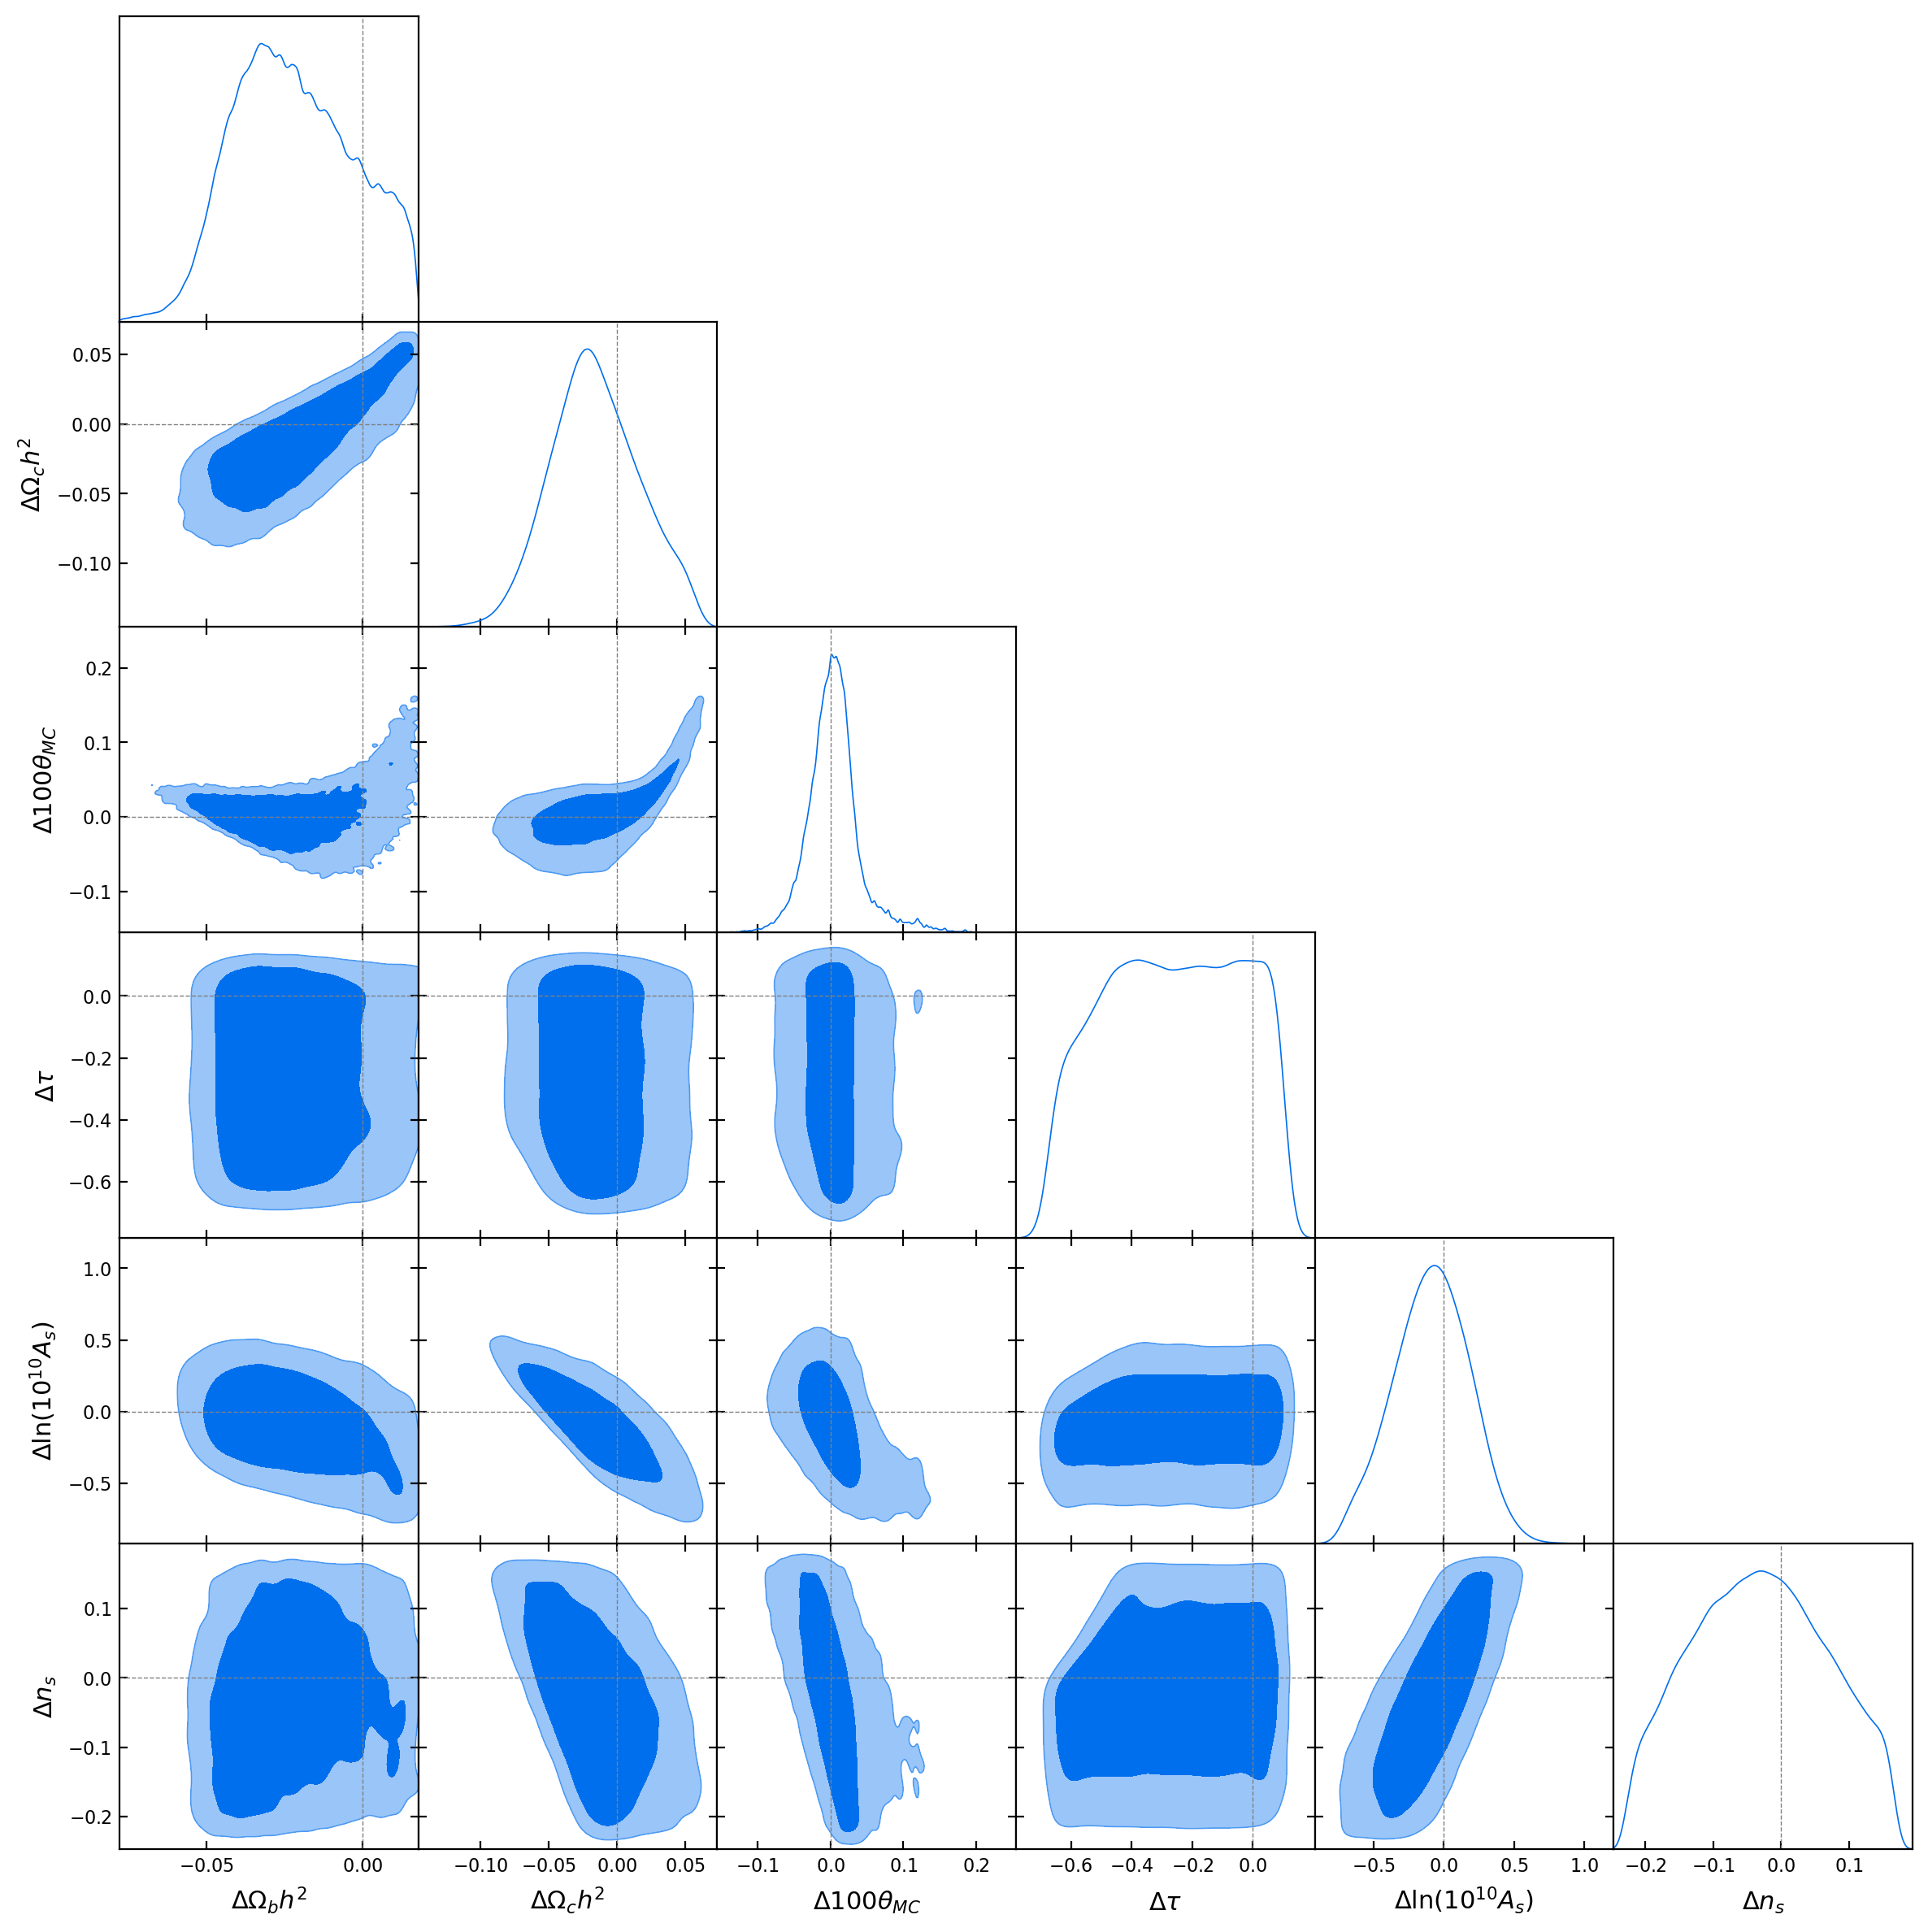

In [4]:
param_names = diff_chain.getParamNames().getRunningNames()
g = plots.get_subplot_plotter()
g.triangle_plot([diff_chain], params=param_names, filled=True, markers={_p:0 for _p in param_names})

Looks non-Gaussian uh? Let's see below how to cope with this!

We need to calculate this integral:

\begin{align}
\Delta \equiv \int_{P(\Delta\theta) > P(0)} P(\Delta\theta) \, d\Delta \theta
\end{align}

which gives the probability mass enclosed in the (full-D) iso-contour that touches the value corresponding to zero shift.

The main problem of this integral is that we have samples from the parameter difference distribution but we cannot associate a probability value to those samples. 
There are two ways to cope with this problem, that we outline below.

# Normalizing flow estimate of parameter shifts:

The first strategy is to build a normalizing flow model for the parameter difference distribution.
We learn from the samples the mapping between parameter spaces that Gaussianizes the distribution. Once this is done we can sample from the learned distribution and compute probability values. The previous integral is then Monte-Carlo integrated.

The code provides a helper function, `tensiometer.mcmc_tension.flow_parameter_shift(diff_chain)`, to create the model, train it and compute the shift significance. We show here how to use it and later how to proceed manually.

Training the normalizing flow is going to take a little while. This is a good time to take break!

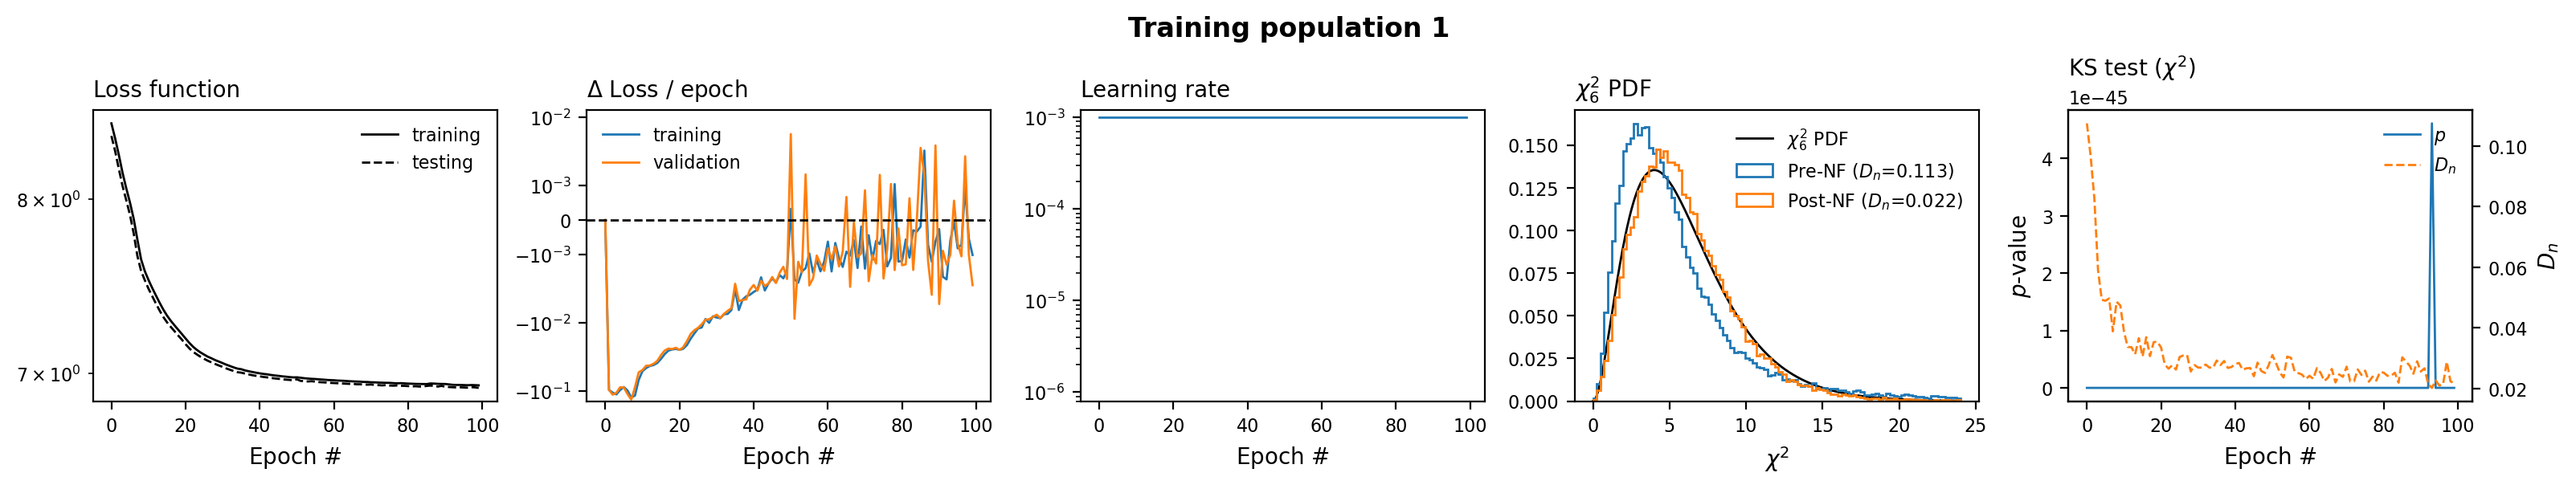

20/20 - 14s - loss: 6.9338 - val_loss: 6.9203 - lr: 0.0010 - 14s/epoch - 676ms/step
* Population optimizer:
    - best model is number 1
    - best loss function is 6.93
    - best validation loss function is 6.92
    - population losses [6.92]


In [5]:
# the helper function passes all keyword arguments downstream so we can easily set manually all options
kwargs = {
          'feedback': 2,  # verbosity level
          'pop_size': 1,  # controls the number of flows that are trained. The best one is then selected. Since time to solution scales linearly with pop_size, it is a good idea to set it to 1 for a first run. 
        }

# call the helper function:
results, diff_flow = tensiometer.mcmc_tension.flow_parameter_shift(diff_chain,   # parameter difference chain
                                      cache_dir=None,  # directory where the trained flow is saved, to save time next time
                                      root_name='sprob',  # name of the cached flow (usefull to have several in the same folder)
                                      **kwargs
                                      )

# unpack results:
shift_P, shift_hi, shift_low = results


In [6]:
print(f'Shift probability considering all parameters:\n',
      f'   P = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'+{utilities.from_confidence_to_sigma(shift_hi)-utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'-{utilities.from_confidence_to_sigma(shift_P)-utilities.from_confidence_to_sigma(shift_low):.3f}')

Shift probability considering all parameters:
    P = 0.99484 +-0.00024 --0.00023
    n_sigma = 2.797 +-0.014 --0.014


## Manual flow calculation

Now we see how to unpack the previous helper function and calculate a tension from scratch.

We first create and train the synthetic probability model. Again this is going to take a bit.
Normally (not in a tutorial) one would save the flow model to cache to avoid retraining every time...

In [7]:
kwargs = {
          'feedback': 1,
          'plot_every': 1000,
          'pop_size': 1,
        }

flow = tensiometer.synthetic_probability.synthetic_probability.flow_from_chain(diff_chain,  # parameter difference chain
                                                         **kwargs)

* Initializing samples
* Initializing fixed bijector
* Initializing trainable bijector
* Initializing training dataset
* Initializing transformed distribution
* Initializing loss function
* Training
Epoch 1/100
20/20 - 38s - loss: 8.4533 - val_loss: 8.3800 - lr: 0.0010 - 38s/epoch - 2s/step
Epoch 2/100
20/20 - 7s - loss: 8.3487 - val_loss: 8.2886 - lr: 0.0010 - 7s/epoch - 357ms/step
Epoch 3/100
20/20 - 7s - loss: 8.2622 - val_loss: 8.2056 - lr: 0.0010 - 7s/epoch - 349ms/step
Epoch 4/100
20/20 - 7s - loss: 8.1816 - val_loss: 8.1251 - lr: 0.0010 - 7s/epoch - 365ms/step
Epoch 5/100
20/20 - 8s - loss: 8.0938 - val_loss: 8.0244 - lr: 0.0010 - 8s/epoch - 380ms/step
Epoch 6/100
20/20 - 9s - loss: 7.9698 - val_loss: 7.8762 - lr: 0.0010 - 9s/epoch - 447ms/step
Epoch 7/100
20/20 - 9s - loss: 7.8025 - val_loss: 7.7102 - lr: 0.0010 - 9s/epoch - 432ms/step
Epoch 8/100
20/20 - 9s - loss: 7.6629 - val_loss: 7.6072 - lr: 0.0010 - 9s/epoch - 436ms/step
Epoch 9/100
20/20 - 9s - loss: 7.5816 - val_loss: 

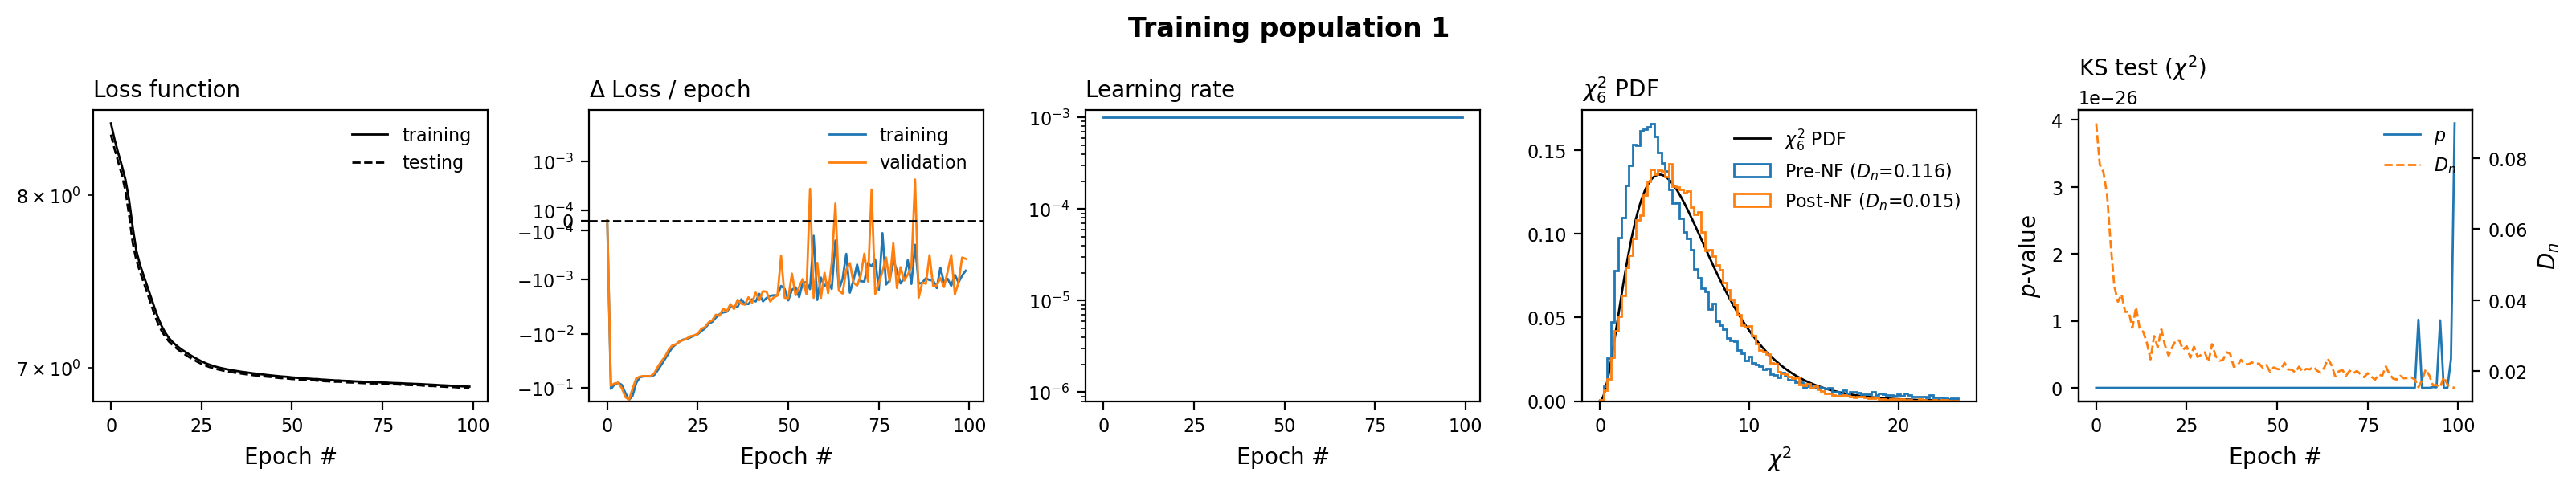

In [8]:
# we can plot training summaries to make sure training went smoothly:
flow.training_plot()

In [9]:
# calculate the shift probability:
shift_P, shift_low, shift_hi = mcmc_tension.estimate_shift(flow)
# print the results:
print(f'Shift probability considering all parameters:\n',
      f'   P = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'+{utilities.from_confidence_to_sigma(shift_hi)-utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'-{utilities.from_confidence_to_sigma(shift_P)-utilities.from_confidence_to_sigma(shift_low):.3f}')

Shift probability considering all parameters:
    P = 0.99599 +0.00020 -0.00021
    n_sigma = 2.877 +0.016 -0.016


Note that there is some variance in the result due to initialization. You can repeat the above calculation some times to evaluate the variance.

We can now plot the learned distribution. To do so we draw some samples from the learned distribution and then feed them to getdist plotting:

In [10]:
# sample the flow:
N = 10000
flow_samples = flow.MCSamples(N)

# build Gaussian approximation:
gaussian_approx = tensiometer.gaussian_tension.gaussian_approximation(diff_chain)

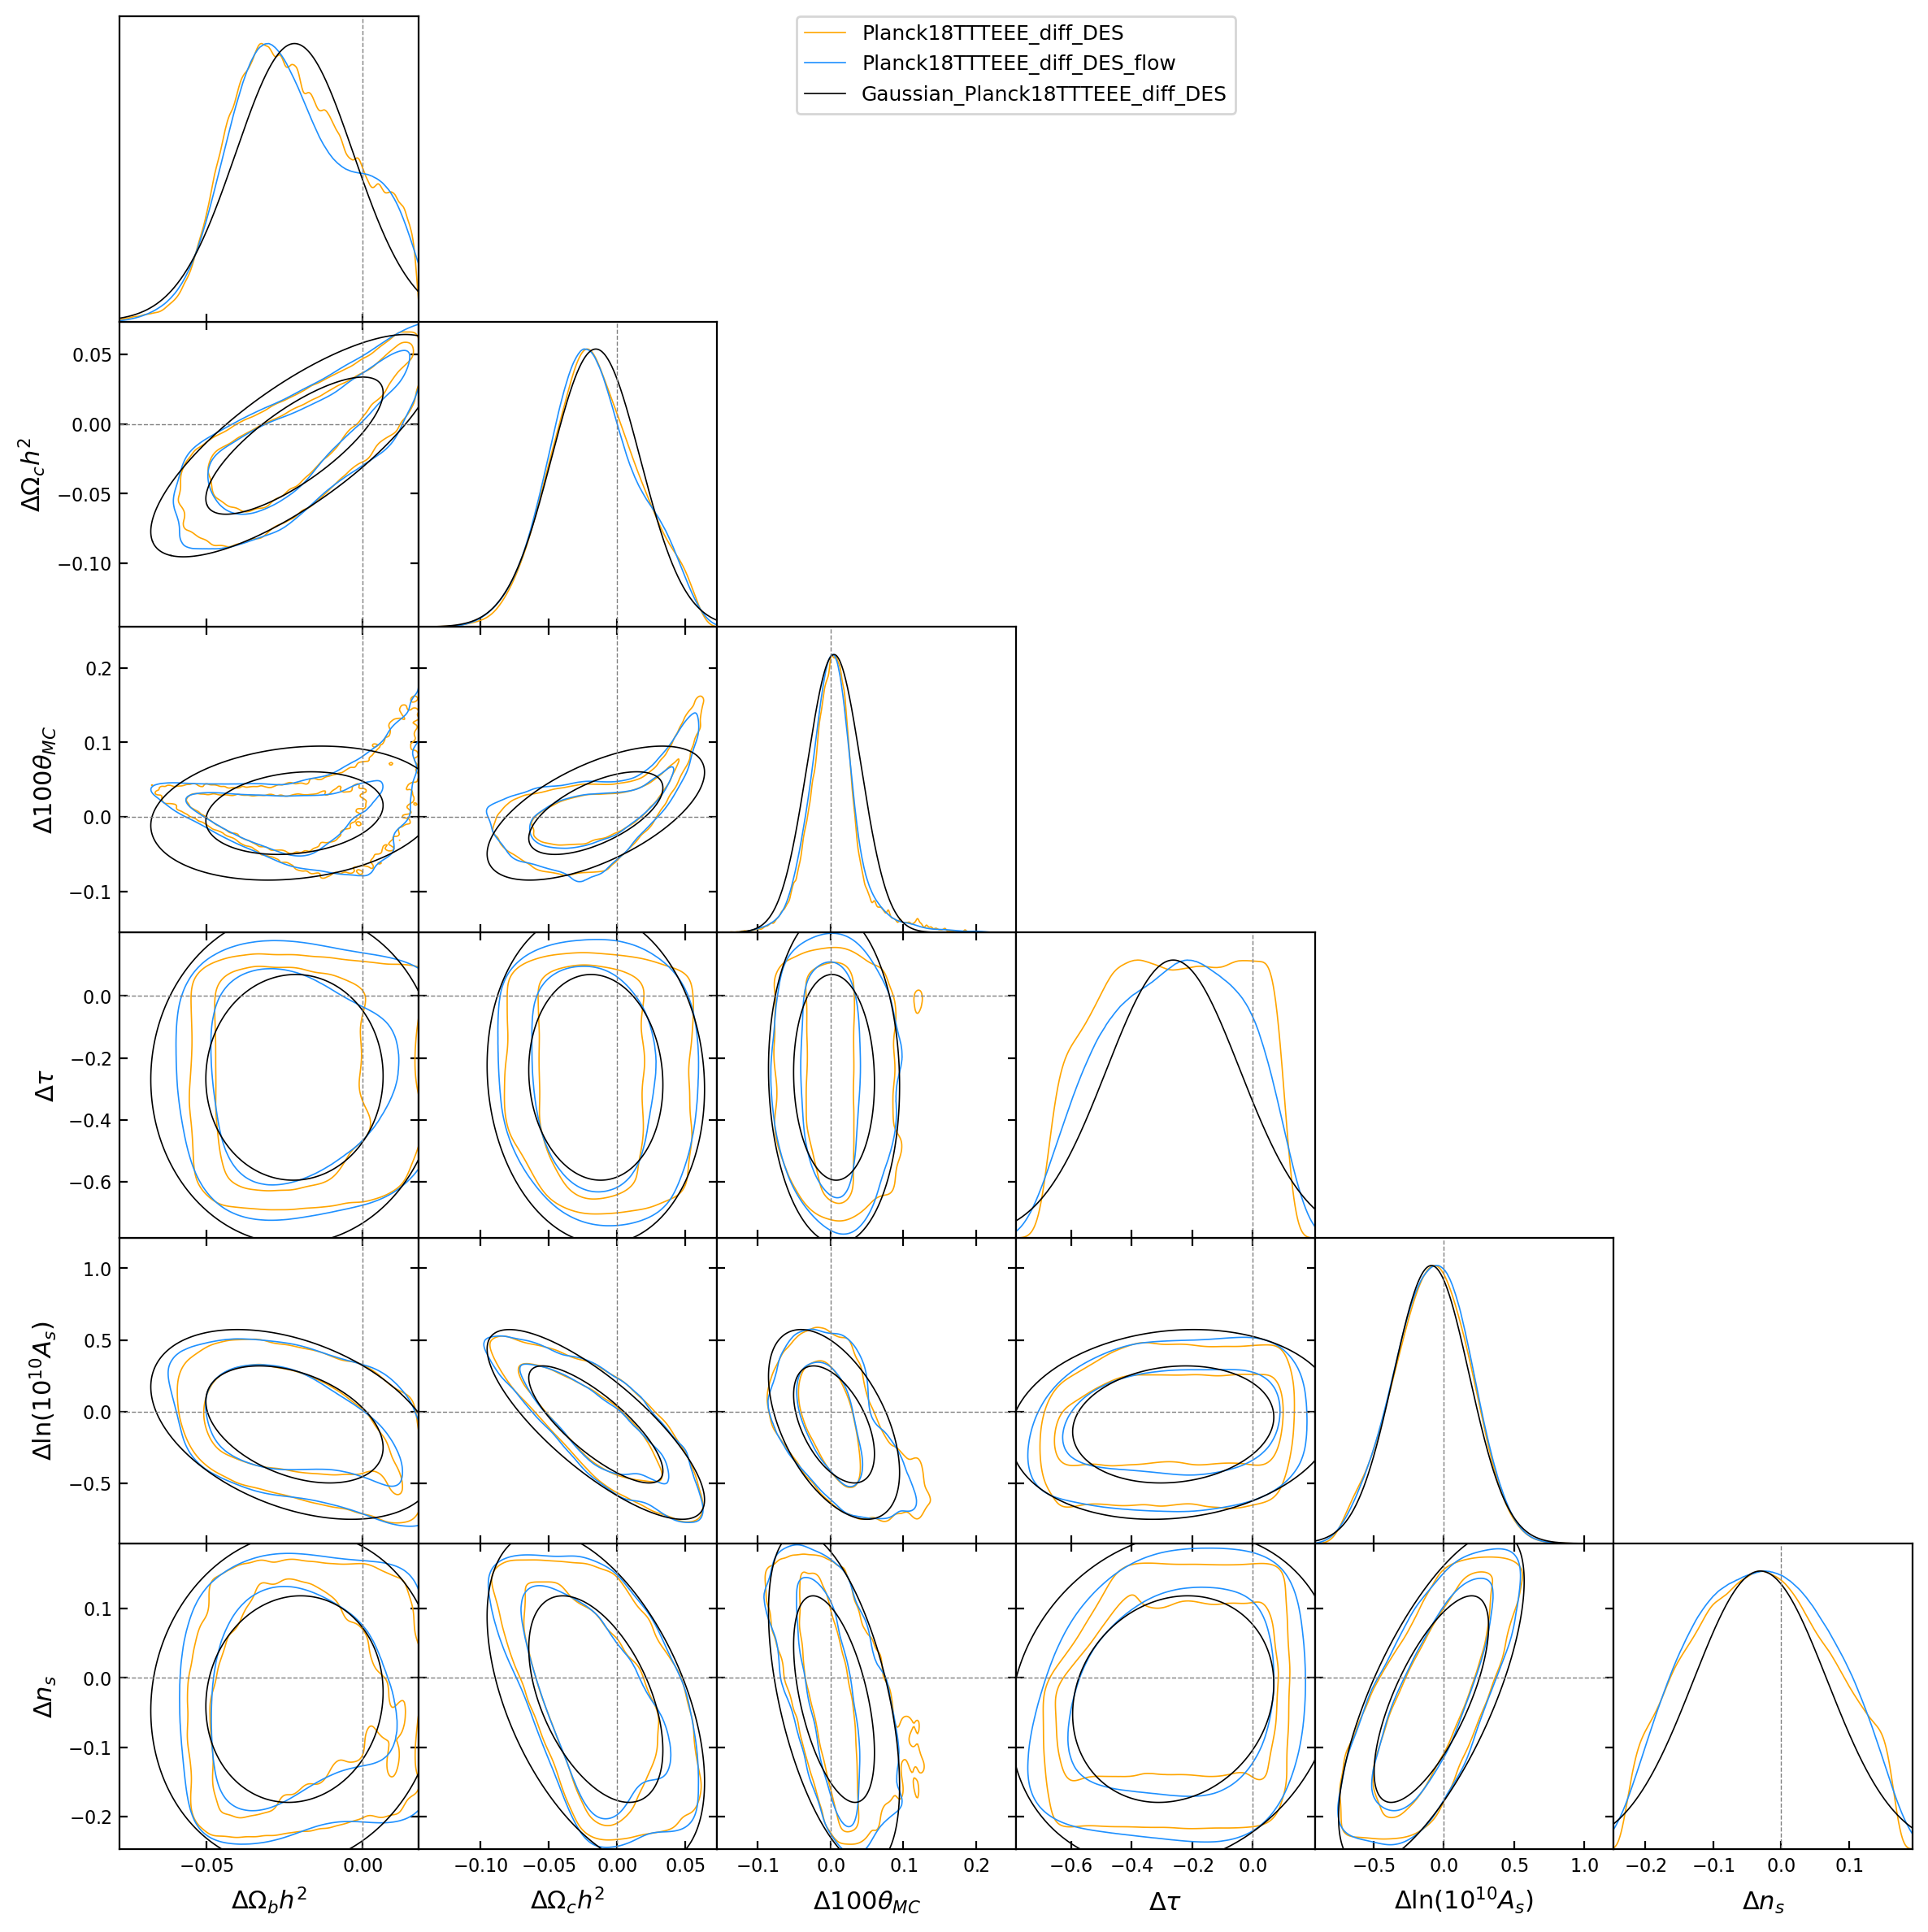

In [11]:
colors=['orange', 'dodgerblue', 'k']
g = plots.get_subplot_plotter()
g.settings.num_plot_contours = 2
g.triangle_plot([diff_chain, flow_samples, gaussian_approx], params=param_names,
                filled=False, markers={_p:0 for _p in param_names},
                colors=colors, diag1d_kwargs={'colors':colors})

As we can see the two distributions match astonishingly well, capturing all non-Gaussian feature that we can identify in this plot.

If you are interested in more details about normalizing flow modeling of probability distributions check out the synthetic probability tutorial!

# KDE estimate of parameter shifts:

We first run the KDE algorithm with default settings and high feedback to have a sense of its inner workings:

In [12]:
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift(diff_chain, feedback=10)

# print the results:
print(f'Shift probability considering all parameters:\n',
      f'   P = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'+{utilities.from_confidence_to_sigma(shift_hi)-utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'-{utilities.from_confidence_to_sigma(shift_P)-utilities.from_confidence_to_sigma(shift_low):.3f}')

Dimension       : 6
N    samples    : 1339837
Neff samples    : 1145806.18
Smoothing scale : [0.056 0.056 0.056 0.056 0.056 0.056]
Building KD-Tree with leafsize = 400
Neighbours elimination
neighbor_elimination: chunk 1
    surviving elements 2773 of 1257304
neighbor_elimination: chunk 2
    surviving elements 2489 of 1257304
neighbor_elimination: chunk 3
    surviving elements 2414 of 1257304
neighbor_elimination: chunk 4
    surviving elements 2378 of 1257304
neighbor_elimination: polishing


100%|##########| 2378/2378 [02:42<00:00, 14.61it/s]


    surviving elements 2337 of 1257304
KDE method: neighbor_elimination
Time taken for KDE calculation: 253.1 (s)
Shift probability considering all parameters:
    P = 0.99824 +0.00004 -0.00004
    n_sigma = 3.128 +0.006 -0.006


As we can see the algorithm proceeds in two steps, elimination of points that are clearly above the probability of zero shift based on the probability estimate containing just a few nearest points and then brute force polishing of the leftover points. This gets the right answer and takes a fairly reasonable amount of time.

You could try to run this cell with method='brute_force' to see the type of performance improvement that this algorithm achieves.

One key parameter in the estimate of the KDE shift is the smoothing scale for the pdf.
The default choice is the one that minimizes the mean integrated square error (MISE) under assumptions of Gaussianity.

In [13]:
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift(diff_chain, scale='MISE', feedback=0)

# print the results:
print(f'Shift probability considering all parameters:\n',
      f'   P = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'+{utilities.from_confidence_to_sigma(shift_hi)-utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'-{utilities.from_confidence_to_sigma(shift_P)-utilities.from_confidence_to_sigma(shift_low):.3f}')

Shift probability considering all parameters:
    P = 0.99824 +0.00004 -0.00004
    n_sigma = 3.128 +0.006 -0.006


But we can try different choices. In particular we could try the asyntotic MISE estimator (AMISE):

In [14]:
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift(diff_chain, scale='AMISE', feedback=0)

# print the results:
print(f'Shift probability considering all parameters:\n',
      f'   P = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'+{utilities.from_confidence_to_sigma(shift_hi)-utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'-{utilities.from_confidence_to_sigma(shift_P)-utilities.from_confidence_to_sigma(shift_low):.3f}')

Shift probability considering all parameters:
    P = 0.99875 +0.00003 -0.00003
    n_sigma = 3.227 +0.007 -0.007


which is slightly undersmoothing and hence resulting in a slightly higher tension.

Or we could try the maximum bandwidth that is (by design) oversmoothing:

In [15]:
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift(diff_chain, scale='MAX', feedback=0)

# print the results:
print(f'Shift probability considering all parameters:\n',
      f'   P = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'+{utilities.from_confidence_to_sigma(shift_hi)-utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'-{utilities.from_confidence_to_sigma(shift_P)-utilities.from_confidence_to_sigma(shift_low):.3f}')

Shift probability considering all parameters:
    P = 0.99456 +0.00006 -0.00006
    n_sigma = 2.780 +0.004 -0.004


As we can see the MISE smoothing scale achieves a balance between these two. Overestimating the smoothing scale usually results in slightly smaller tensions.

We can now try the adaptive bandwidth:

In [16]:
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift(diff_chain, scale='BALL', feedback=0)

# print the results:
print(f'Shift probability considering all parameters:\n',
      f'   P = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'+{utilities.from_confidence_to_sigma(shift_hi)-utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'-{utilities.from_confidence_to_sigma(shift_P)-utilities.from_confidence_to_sigma(shift_low):.3f}')

Shift probability considering all parameters:
    P = 0.99660 +0.00005 -0.00005
    n_sigma = 2.929 +0.005 -0.005


As we can see all results are mostly in agreement with each other and this provides an invaluable cross check of the different calculation techniques.

The number of samples used in the calculation can be changed to make sure that everything is converged and makes sense.
Since all algorithms work in a fairly straightforward way on a laptop we encourage to always try and compare different outputs to make sure the result is sensible.

We now verify that the calculation makes physical sense. We know that a difference between these two results mostly lives in a 2 dimensional parameter space so we can do the calculation there and plot the result.

In this case, since we are in two dimensions we can use the fft algorithm that is sensibly faster.

Shift probability considering all parameters:
    P = 0.99733 +0.00004 -0.00005
    n_sigma = 3.003 +0.005 -0.005


<Figure size 600x450 with 0 Axes>

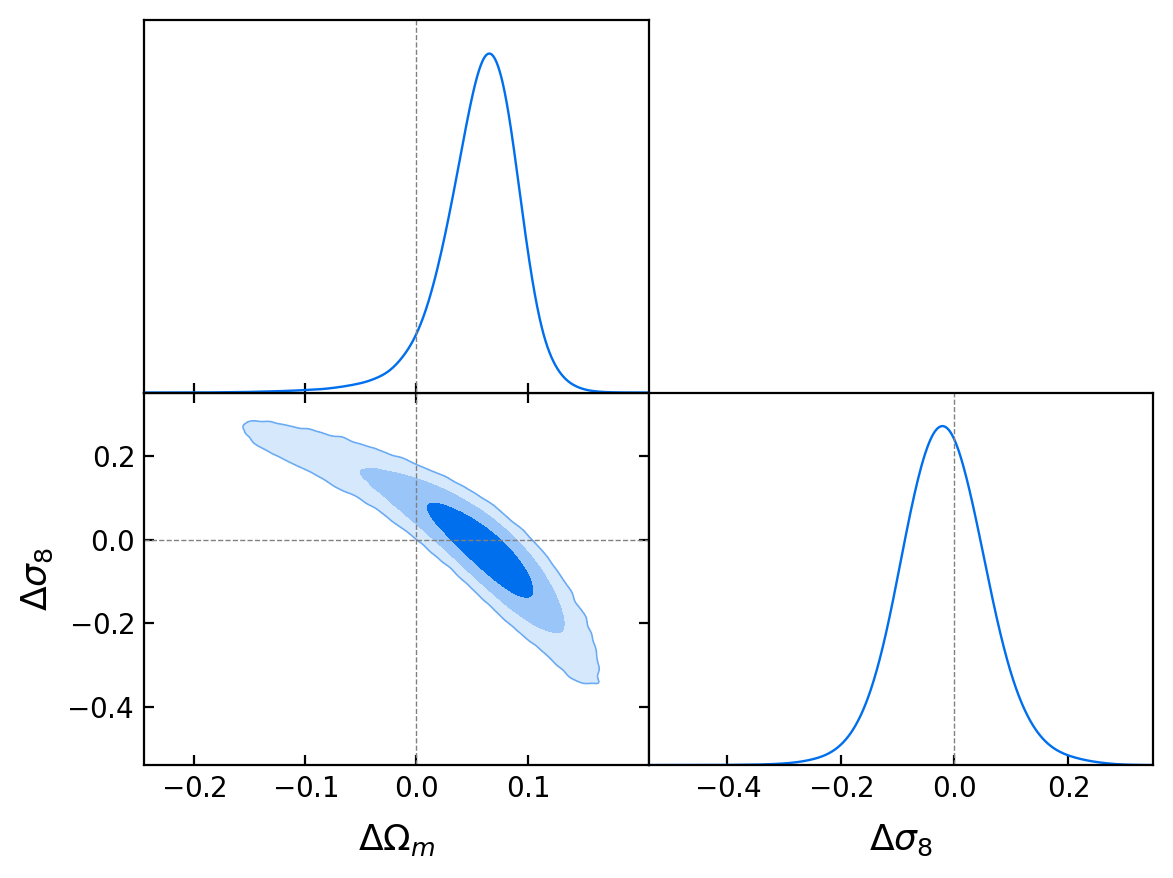

In [17]:
param_names = ['delta_omegam', 'delta_sigma8']
shift_P, shift_low, shift_hi = mcmc_tension.kde_parameter_shift_2D_fft(diff_chain, param_names=param_names, feedback=0)

# print the results:
print(f'Shift probability considering all parameters:\n',
      f'   P = {shift_P:.5f} +{shift_hi-shift_P:.5f} -{shift_P-shift_low:.5f}')
# turn the result to effective number of sigmas:
print(f'    n_sigma = {utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'+{utilities.from_confidence_to_sigma(shift_hi)-utilities.from_confidence_to_sigma(shift_P):.3f}',
      f'-{utilities.from_confidence_to_sigma(shift_P)-utilities.from_confidence_to_sigma(shift_low):.3f}')

# triangle plot with the 2D shift probability:
g = plots.get_single_plotter()
diff_chain.updateSettings({'contours': [0.68, 0.95, shift_P]})
g.settings.num_plot_contours = 3
g.triangle_plot(diff_chain, param_names, filled=True, markers={name:0. for name in param_names});